In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.rawio import BlackrockRawIO

In [2]:
# pull in OSort QC
df_preproc = pd.read_csv('../../results/202512/preproc.csv')[['channel', 'unit', 'keep']]
df_preproc['keep'] = df_preproc['keep'].fillna(0)
df_preproc

,channel,unit,keep
0,1,596,0.0
1,1,612,0.0
2,2,1432,0.0
3,2,1502,0.0
4,2,1543,0.0
...,...,...,...
85,30,156,0.0
86,31,182,0.0
87,31,188,0.0
88,32,167,0.0


In [3]:
# get [clustIDs] where df[keep] = 0
dropped_clustIDs = df_preproc[df_preproc['keep'] != 1]['unit'].tolist()
dropped_clustIDs.extend([0, 99999999])
print(dropped_clustIDs)

[596, 612, 1432, 1502, 1543, 506, 703, 636, 683, 1469, 2405, 2423, 2457, 2481, 1518, 1755, 1348, 1396, 1553, 1566, 1715, 1772, 976, 1042, 1045, 1433, 1799, 1825, 1953, 1712, 2185, 2769, 3203, 3227, 2308, 2323, 264, 571, 1998, 1747, 1901, 1921, 1585, 1736, 1558, 2261, 2280, 1663, 1678, 1373, 1882, 130, 147, 82, 117, 141, 163, 157, 172, 148, 151, 118, 156, 182, 188, 167, 174, 0, 99999999]


In [4]:
def getclustID2spikes(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    ID_spikes_dict = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in ID_spikes_dict: ID_spikes_dict[clustID] = [] # init

        ID_spikes_dict[clustID].append(spike)

    return ID_spikes_dict

## create df with: channel, clustID, spikes, #spikes, avgFR
 

In [5]:
samp_rate = 1000000
neur_spikes_df = []

data_dir = '../../results/202512/osort_mat/sort/5'

for channel_num in range(len(os.listdir(data_dir))):

    channel_mat = sio.loadmat(f'{data_dir}/A{channel_num+1}_sorted_new.mat')

    # get (1 * n_spikes) clusterID & spiketimes
    clust_IDs = channel_mat['assignedNegative'][0]
    spikes = channel_mat['newTimestampsNegative'][0]

    # get clusterID: [spikes]
    ID_spikes_dict = getclustID2spikes(clust_IDs, spikes)

    # 1 row per clustID
    clust_df = pd.DataFrame([
        {
            "channel": channel_num + 1,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in ID_spikes_dict.items()
    ])
    neur_spikes_df.append(clust_df)

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)


In [6]:
# # map old chanIDs (1:32) to true chanIDs (97:128)
# raw = BlackrockRawIO(filename="../../results/202512/datafile_202512b002.ns6", nsx_to_load=[6])
# raw.parse_header()

# sig = raw.header['signal_channels']        # 1-D structured array
# chan_ids   = sig['id'].astype(int)         # true Blackrock ChannelIDs (ordered)

# old2new_chanID = dict(zip(range(1,33), chan_ids))
# neur_spikes_df['channel'] = neur_spikes_df['channel'].map(old2new_chanID)


## map channel to label

In [7]:
# map old chanIDs (1:32) to true chanIDs (97:128)
raw = BlackrockRawIO(filename="../../results/202512/datafile_202512b002.ns6", nsx_to_load=[6])
raw.parse_header()

sig = raw.header['signal_channels']        # 1-D structured array
chan_ids   = sig['id'].astype(int)         # true Blackrock ChannelIDs (ordered)

old2new_chanID = dict(zip(range(1,33), chan_ids))
# neur_spikes_df['channel'] = (neur_spikes_df['channel']
#                          .astype(int)          # 1.0→1, etc.
#                          .replace(old2new_chanID)     # 1..32 → 97..128, others untouched
#                          .astype(float)      # integer dtype (nullable); use .astype(int) if no NAs
#                         )
neur_spikes_df['channel'] = neur_spikes_df['channel'].map(old2new_chanID).fillna(neur_spikes_df['channel']).astype(float)
print(np.unique(neur_spikes_df['channel']))
neur_spikes_df

[ 98. 101. 102. 103. 104. 105. 106. 107. 108. 109. 111. 112. 113. 116.]


,channel,clustID,spikes,#spikes,avgFR
0,98.0,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888
1,101.0,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957
2,102.0,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268
3,102.0,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394
4,102.0,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609
5,103.0,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596
6,104.0,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269
7,104.0,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847
8,105.0,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766
9,105.0,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493


In [18]:
# map channels to regions
channelInfo = sio.loadmat('../../results/202512/pt_info/202512_DI_ChannelMap.mat')
channelMap = channelInfo['ChannelMap1'].flatten()
labelMap = channelInfo['LabelMap'].flatten()
labelMap = np.array([str(label.squeeze())[1:] for label in labelMap])  # convert to str

# dict after removing nan keys
nan_mask = ~np.isnan(channelMap)
channel2label = dict(zip(channelMap[nan_mask], labelMap[nan_mask]))

neur_spikes_df['region'] = neur_spikes_df['channel'].map(channel2label).fillna(neur_spikes_df['channel']).apply(lambda x: str(x))


In [19]:
# inspect
n_neurs = len(neur_spikes_df)
print(f'#neurs: {n_neurs}')
eg_spikes = neur_spikes_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
neur_spikes_df

#neurs: 23
last 5 spikes (s): [1620.1233     1620.19223333 1620.53116667 1620.94453333 1621.08233333]
last 5 spikes (min): [27.002055   27.00320389 27.00885278 27.01574222 27.01803889]


,channel,clustID,spikes,#spikes,avgFR,region
0,98.0,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,LOFC2
1,101.0,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,LOFC5
2,102.0,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,LOFC6
3,102.0,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,LOFC6
4,102.0,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,LOFC6
5,103.0,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,LOFC7
6,104.0,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269,LOFC8
7,104.0,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,LOFC8
8,105.0,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766,LACC1
9,105.0,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493,LACC1


### psychopy

In [20]:
df_subjs = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
subj_df = df_subjs[df_subjs['subj'] == '12'].copy()
subj_df

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,0.0,0.224,0.2,0.34,1.0,1.0,0.0,-0.116,0.116,...,NaN,NaN,NaN,NaN,NaN,False,False,False,34.5,20.0
236,0.0,0.0,0.292,0.2,0.38,1.0,1.0,0.0,-0.088,0.088,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,32.0
237,1.0,0.0,0.252,0.2,0.38,1.0,1.0,0.0,-0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,23.5
238,0.0,0.0,0.384,0.2,0.38,1.0,1.0,0.0,0.004,0.004,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,38.0


### get FRs

In [21]:
def get_phase_spikes_and_FRs(subj_df, neur_spikes_df, phase, prestart, phase_stop, size, dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window '''
    
    # if phase == 'baseline': prestart = .3 # to prevent spillover from feedback

    # bin edges & centers for hists & plots
    bin_edges = np.arange(prestart, phase_stop + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & phase_stop edges
    n_bins = len(bin_edges) - 1

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.zeros((len(subj_df), len(neur_spikes_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(subj_df), len(neur_spikes_df), n_bins))

    for trial_i, trial_row in subj_df.iterrows():

        trial_phase_onset = trial_row[f'{phase}.started']

        for neur_i, neur_row in neur_spikes_df.iterrows():

            spike_train = np.zeros(n_bins)

            # phase spike times, aligned
            trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= trial_phase_onset + prestart) &
                                                    (neur_row['spikes'] <= trial_phase_onset + phase_stop)]
            trial_phase_spikes = trial_phase_spikes - trial_phase_onset
            trial_neur_spikes[trial_i, neur_i] = trial_phase_spikes

            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt

            # for this trial and neuron, store smoothed FRs across bins
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)
            trial_neur_FRs[trial_i, neur_i, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# bin params
prestart, size, dt = -.5, .02, .001
# # for norming by baseline
# phase, phase_stop = 'baseline', 1
# base_spikes, base_FRs, bin_centers = get_phase_spikes_and_FRs(subj_df, neur_spikes_df, phase, prestart, phase_stop, size, dt)

### create conditions

In [92]:
spikes, FRs, FRs_normed, bin_centers, cond1_ids, cond2_ids, cond1_label, cond2_label, dur = {}, {}, {}, {}, {}, {}, {}, {}, {}
base_ids, base_label = {}, {}
dur['baseline'], dur['stim'], dur['delay'], dur['feedback'] = 1, 1, 1.5, 1
for phase in ['baseline', 'stim', 'delay', 'feedback']:
    
    # get spikes_times & FRs for phase
    spikes[phase], FRs[phase], bin_centers[phase] = get_phase_spikes_and_FRs(subj_df, neur_spikes_df, phase, prestart, dur[phase], size, dt)
    
    if phase == 'baseline': continue
    if phase in ['delay', 'feedback']: continue
    FRs_normed[phase] = FRs[phase] / FRs['baseline'].mean(axis=(0, 2), keepdims=True)

    # interesting contrasts depend on phase
    if phase == 'stim':
        cond1_ids[phase] = subj_df[subj_df['stim_pos_aligned'] > 0].index
        cond2_ids[phase] = subj_df[subj_df['stim_pos_aligned'] < 0].index
        cond1_label[phase], cond2_label[phase] = 'right of mid', 'left of mid'

        cond1_ids[phase] = subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index
        cond2_ids[phase] = subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index
        cond1_label[phase], cond2_label[phase] = 'right of div', 'left of div' 

        cond1_ids[phase] = subj_df[abs(subj_df['stim_pos_aligned']) > 0.2].index
        cond2_ids[phase] = subj_df[abs(subj_df['stim_pos_aligned']) < 0.2].index
        cond1_label[phase], cond2_label[phase] = 'easy', 'hard'

        # cond1_ids[phase] = subj_df[subj_df['condition'] == 'rew_comp'].index
        # base_ids[phase] = subj_df[subj_df['condition'] == 'baseline'].index
        # cond2_ids[phase] = subj_df[subj_df['condition'] == 'pen_comp'].index
        # cond1_label[phase], base_label[phase], cond2_label[phase] = 'gain_comp', 'base', 'loss_comp'

        cond1_ids[phase] = subj_df[subj_df['condition'] != 'baseline'].index
        cond2_ids[phase] = subj_df[subj_df['condition'] == 'baseline'].index
        cond1_label[phase], cond2_label[phase] = 'comp', 'base'


    elif phase == 'delay':
        cond1_ids[phase] = subj_df[abs(subj_df['stim_pos_aligned']) > 0.2].index
        cond2_ids[phase] = subj_df[abs(subj_df['stim_pos_aligned']) < 0.2].index
        cond1_label[phase], cond2_label[phase] = 'easy', 'hard'
    elif phase == 'feedback':
        cond1_ids[phase] = subj_df[subj_df['outcome'] == 3].index
        cond2_ids[phase] = subj_df[subj_df['outcome'] == 1].index
        cond1_label[phase], cond2_label[phase] = '3 coins', '1 coin'

    print(phase.upper())
    print('spike_times (#trials, #neurs)')
    print(f'{cond1_label[phase]}: {spikes[phase][cond1_ids[phase], :].shape}')
    print(f'{cond2_label[phase]}: {spikes[phase][cond2_ids[phase], :].shape}')
    # print(f'{base_label[phase]}: {spikes[phase][base_ids[phase], :].shape}') # extra
    print()
    print('FRs (#trials, #neurs, #bins)')
    print(f'{cond1_label[phase]}: {FRs_normed[phase][cond1_ids[phase], :, :].shape}')
    print(f'{cond2_label[phase]}: {FRs_normed[phase][cond2_ids[phase], :, :].shape}')
    # print(f'{base_label[phase]}: {FRs_normed[phase][base_ids[phase], :, :].shape}') # extra
    print()

STIM
spike_times (#trials, #neurs)
comp: (160, 23)
base: (80, 23)

FRs (#trials, #neurs, #bins)
comp: (160, 23, 1500)
base: (80, 23, 1500)



## plots

### phase neurons

In [ ]:
# phase = 'feedback'
# n_rows, n_cols = 5, 5
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# for neur_i in range(n_neurs):

#     # no norming for baseline itself
#     data = FRs_normed[phase][:, neur_i, :] if phase!='baseline' else FRs[phase][:, neur_i, :]
#     mu = data.mean(axis=0)
#     sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#     axs[ax].plot(bin_centers[phase], mu, alpha=0.9)
#     axs[ax].fill_between(bin_centers[phase], mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
#     # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} (s)', xticks=np.linspace(-.25, 1.5, 8), xlim=[0, dur[phase]])
#     if phase!='baseline': axs[ax].set(ylim=[0, 2])
#     ax += 1

# plt.suptitle(phase, y=1.01, fontsize=16)
# plt.tight_layout()
# plt.show()


In [74]:
# if phase == 'stim': plot_neur_i = 19
# elif phase == 'delay': plot_neur_i = 21
# elif phase == 'feedback': plot_neur_i = 4

# # raster
# plt.figure(figsize=(4,3))
# plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
# plt.eventplot(spikes[phase][:, plot_neur_i], orientation='horizontal')
# plt.axvline(0, color='black', linestyle='-')
# plt.ylabel('trial')
# plt.xlabel(f'time from {phase} (s)')
# plt.xlim([-.0, dur[phase]])
# plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_raster.eps', format='eps', dpi=300, bbox_inches='tight')
# plt.show()

# # psth
# plt.figure(figsize=(4,3))
# plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
# data = FRs_normed[phase][:, plot_neur_i, :]
# mu = data.mean(axis=0)
# sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
# plt.plot(bin_centers[phase], mu, alpha=0.9)
# plt.fill_between(bin_centers[phase], mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
# # plt.axvline(0, color='black', linestyle='-')
# plt.ylabel('normed FR (Hz)')
# plt.xlabel(f'time from {phase} (s)')
# plt.xlim([-.0, dur[phase]])
# plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_PSTH.eps', format='eps', dpi=300, bbox_inches='tight')
# plt.show()


### contrasts

In [88]:
# phase = 'stim'
# n_rows, n_cols = 5, 5
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# for neur_i in range(n_neurs):

#     for contrast_label, contrast_ids, color in zip([cond1_label[phase], base_label[phase], cond2_label[phase]],
#                                                    [cond1_ids[phase], base_ids[phase], cond2_ids[phase]],
#                                                    ['b', 'k', 'r']):
#         # if contrast_label != 'base': continue
#         data = FRs_normed[phase][contrast_ids, neur_i, :]
#         mu = data.mean(axis=0)
#         sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
#         axs[ax].plot(bin_centers[phase], mu, color=color, alpha=0.9, label=contrast_label)
#         axs[ax].fill_between(bin_centers[phase], mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

#     axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} (s)', xticks=np.linspace(-.25, 1.5, 8), xlim=[0, dur[phase]], ylim=[0, 3])
#     axs[ax].legend(loc='upper right')
#     ax += 1

# plt.suptitle(phase, y=1.01, fontsize=16)
# plt.tight_layout()
# plt.show()


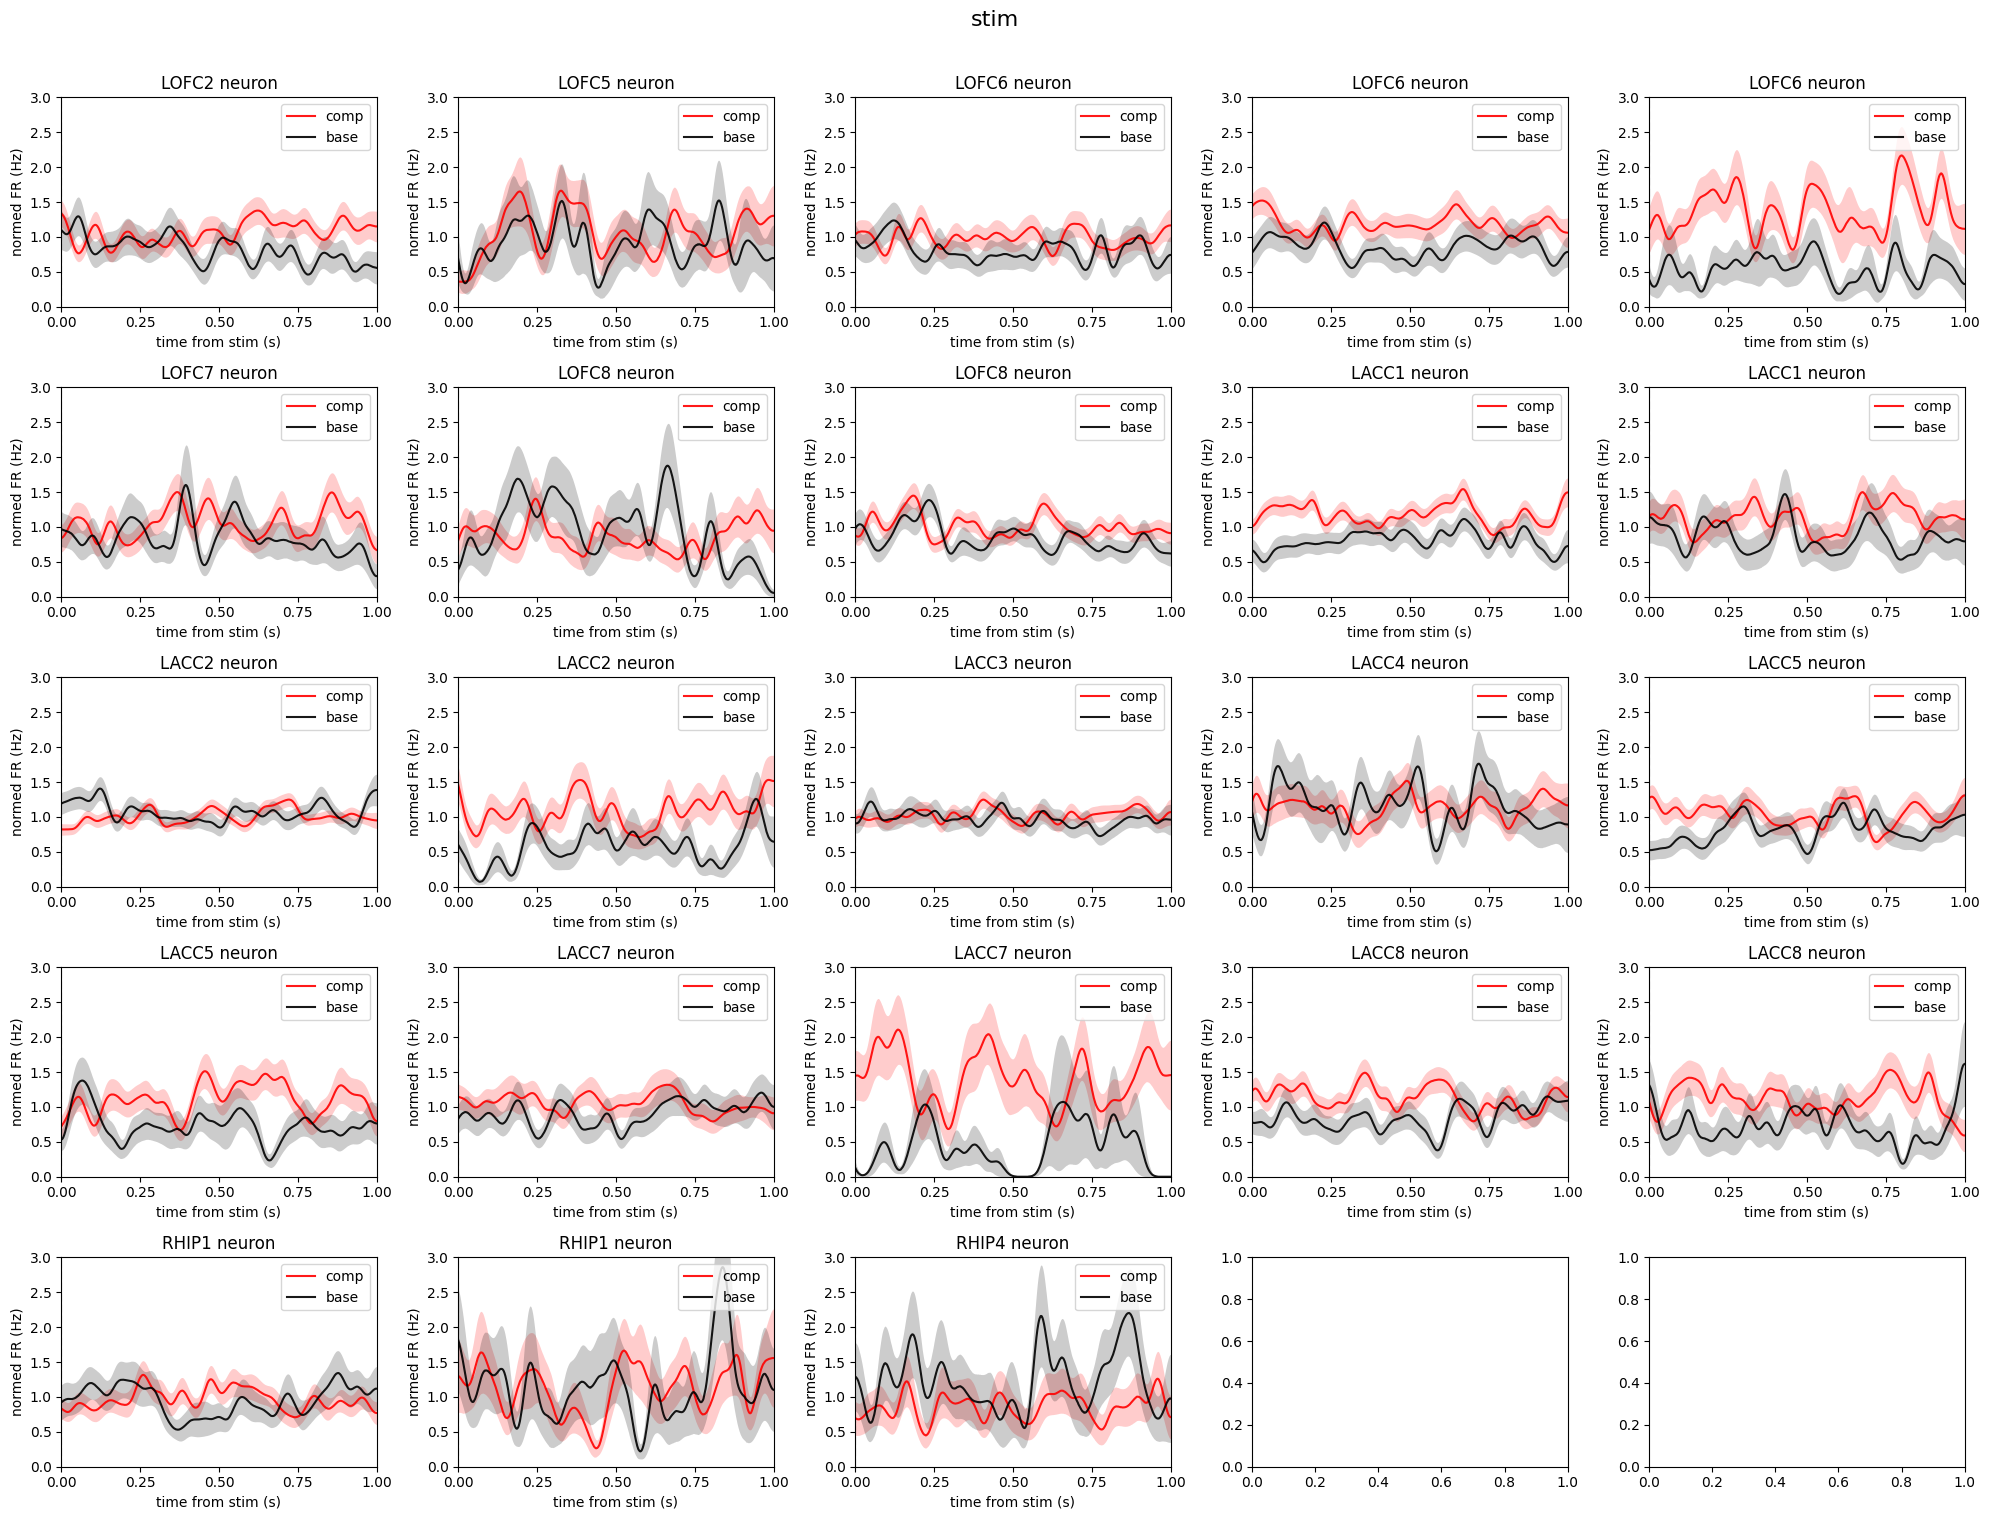

In [ ]:
phase = 'stim'
n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    for contrast_label, contrast_ids, color in zip([cond1_label[phase], cond2_label[phase]],
                                                   [cond1_ids[phase], cond2_ids[phase]],
                                                   ['b', 'r']):
        data = FRs_normed[phase][contrast_ids, neur_i, :]
        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers[phase], mu, color=color, alpha=0.9, label=contrast_label)
        axs[ax].fill_between(bin_centers[phase], mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} (s)', xticks=np.linspace(-.25, 1.5, 8), xlim=[0, dur[phase]], ylim=[0, 3])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


KeyError: 'feedback'

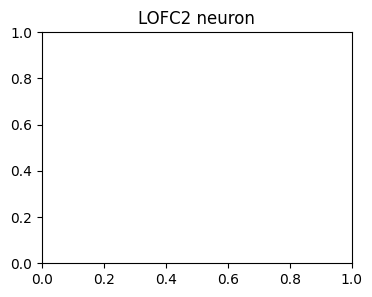

In [86]:
phase = 'feedback'
if phase == 'stim': plot_neur_i = 19
elif phase == 'delay': plot_neur_i = 21
elif phase == 'feedback': plot_neur_i = 4

# raster
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
raster_list = list(spikes[phase][cond2_ids[phase], plot_neur_i]) + list(spikes[phase][cond1_ids[phase], plot_neur_i])
color_list = ['red'] * len(cond2_ids[phase]) + ['blue'] * len(cond1_ids[phase])
plt.eventplot(raster_list, orientation='horizontal', colors=color_list)
plt.axvline(0, color='black', linestyle='-')
plt.ylabel('trial')
plt.xlabel(f'time from {phase} (s)')
plt.xlim([-.0, dur[phase]])
plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_raster.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

# psth
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_i]} neuron')
for contrast_label, contrast_ids, color in zip([cond1_label[phase], cond2_label[phase]],
                                        [cond1_ids[phase], cond2_ids[phase]],
                                        ['b', 'r']):
    data = FRs_normed[phase][contrast_ids, plot_neur_i, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers[phase], mu, color=color, alpha=0.9, label=contrast_label)
    plt.fill_between(bin_centers[phase], mu - sderr, mu + sderr, color=color, alpha=0.2, linewidth=0)

plt.axvline(0, color='black', linestyle='-')
plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from {phase} (s)')
plt.xlim([-.0, dur[phase]])
plt.legend(loc='upper left')
plt.savefig(f'../../data/eps_figs/eg_{phase}_neur_PSTH.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


### duration checks for stim & feedback

In [17]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()